Задача: классифицировать фото футболистов 10-ти команд по их форме

Подключение модулей

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 28.6 MB/s 
     |████████████████████████████████| 396 kB 72.3 MB/s 
     |████████████████████████████████| 952 kB 61.0 MB/s 
     |████████████████████████████████| 829 kB 73.7 MB/s 
     |████████████████████████████████| 596 kB 69.4 MB/s 
     |████████████████████████████████| 133 kB 73.2 MB/s 
     |████████████████████████████████| 1.1 MB 66.7 MB/s 
     |████████████████████████████████| 271 kB 74.6 MB/s 
     |████████████████████████████████| 144 kB 74.7 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d5ef054b5b66f0fbd20ba87feda2ff2704a4e681e51814349e507d1ae24c1a9a
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfu

In [ ]:
import torch

from torch.utils.data import DataLoader, random_split

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer

from torch import nn
import torch.nn.functional as F

from sklearn.metrics import f1_score
from numpy import argmax, array

from scipy.io import loadmat

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

Подключение к диску с данными

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/footballteams'

Mounted at /content/drive


Определение глобальных переменных и констант

In [ ]:
# constants

TRAIN_VAL_ROOT = path + "/Train/GrayScaleTrain"
TEST_ROOT = path + "/Test/GrayScaleTest"

# train_len = 3408
TRAIN_VAL_LEN = 3398

TRAIN_LEN = 3200
VAL_LEN = TRAIN_VAL_LEN - TRAIN_LEN # = 198

TEST_LEN = 1177

BATCH_SIZE = 256
EPOCHS = 30

train_logs_list = []
val_logs_list = []

LABELS_LIST = [
    'Arsenal',
    'Barcelona',
    'Bayern',
    'Chelsea',
    'Juventus',
    'Liverpool',
    'ManchesterCity',
    'ManchesterUnited',
    'PSG',
    'Real']

TRANSFORM = transforms.Compose([                     
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.Grayscale(),
    transforms.Resize([320, 320]),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),

    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Папки с картинками -> dataset -> dataloader

Изображения разбиваются на тренировочную и валидационную выборки

In [ ]:
train_val_dataset = datasets.ImageFolder(root=TRAIN_VAL_ROOT, transform=TRANSFORM)
train_dataset, val_dataset = random_split(train_val_dataset, (TRAIN_LEN, VAL_LEN))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2) 

Просмотр преобразованных картинок, подающихся на вход

In [ ]:
def show_samples(dataset, n):
        figure = plt.figure(figsize=(10, 10))
        cols, rows = n, n
        for i in range(1, cols * rows + 1):

            sample_idx = torch.randint(len(dataset), size=(1,)).item()
            img, label = dataset[sample_idx]

            figure.add_subplot(rows, cols, i)
            plt.title(LABELS_LIST[label])
            plt.axis("off")
            
            plt.imshow(transforms.ToPILImage()(img), cmap="gray")

        plt.show()

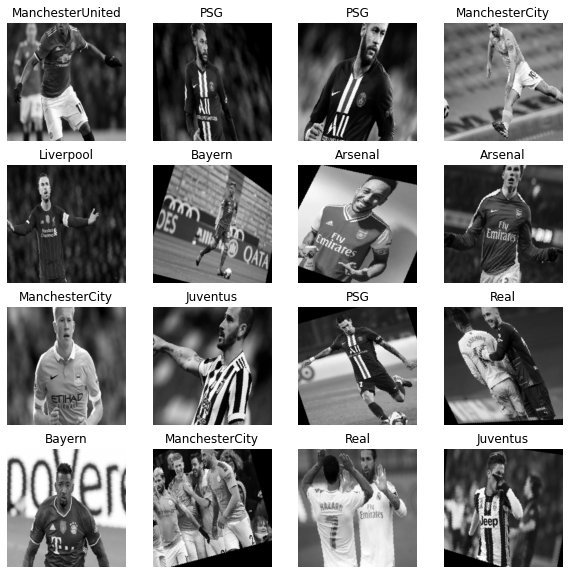

In [ ]:
show_samples(train_dataset, 4)

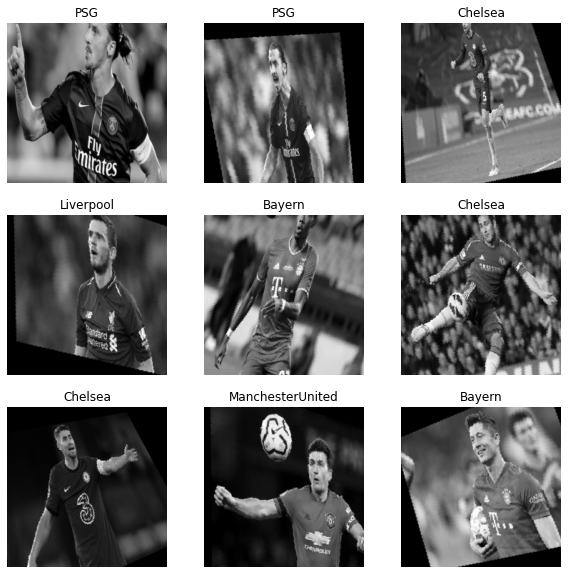

In [ ]:
show_samples(val_dataset, 3)

Класс первой, более простой модели (2.7 M params)


In [ ]:
# Define a convolution neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*106*106, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))
        
        output = output.view(-1, 24*106*106)
        
        output = self.fc1(output)
      
        return output

Более сложная модель (> 20 M params)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

Класс для обучения модели
(модель передается как параметр при инициализации)

In [ ]:
class Classifier(pl.LightningModule):
      
    def __init__(self, model):
            super().__init__()
            self.model = model
            self.loss_func = nn.CrossEntropyLoss()
  
      # Настраиваются параметры обучения
    def training_step(self, batch, batch_idx):
            x, y = batch

            pred = self.model(x)
            
            loss = self.loss_func(pred, y)
            _, pred = torch.max(pred.data, 1)
            
            accuracy =  f1_score(y.detach().cpu().numpy(),
                        pred.detach().cpu().numpy(),
                        average='macro')
            
            self.log("train_accuracy_f1", accuracy,  prog_bar=True) # on_step=True, on_epoch=True,
            self.log("train_loss", loss,  prog_bar=True)
            
            train_logs_list.append(accuracy) 
            
            return loss

    def validation_step(self, batch, batch_idx):
            x, y = batch
            pred = self.model(x) 
            loss = self.loss_func(pred, y)
            _, pred = torch.max(pred.data, 1)
            accuracy =  f1_score(y.detach().cpu().numpy(),
                        pred.detach().cpu().numpy(),
                        average='macro')
            
            self.log("val_accuracy_f1", accuracy,  prog_bar=True) 
            
            val_logs_list.append(accuracy) 
            
            return loss

    # Настраиваются параметры тестирования
    def test_step(self, batch, batch_idx):
            x, y = batch
            
            pred = self.model(x)
            loss = self.loss_func(pred, y)
            pred = torch.argmax(pred, dim=1)
            accuracy_average = torch.sum(y == pred).item() / (len(y) * 1.0)
            accuracy_f1 =  f1_score(y.detach().cpu().numpy(),
                            pred.detach().cpu().numpy(),
                            average='macro')
            
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_accuracy_average', torch.tensor(accuracy_average), prog_bar=True)
            self.log('test_accuracy_f1', torch.tensor(accuracy_f1), prog_bar=True)
            
            output = dict({
                'test_loss': loss,
                'test_acc': torch.tensor(accuracy_average)})
            
            return output

    # Конфигурируется оптимизатор
    def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
            return optimizer
        
    def save(self):
            path = "/content/drive/My Drive/resnet_2"
            torch.save(self.model.state_dict(), path)

In [ ]:
def make_graph(y, name):
    x = [i  for i in range(len(y))]
    plt.plot(x, y)
    plt.show()
    plt.savefig('/content/drive/My Drive/' + name)

Опция обучения и тестирования с нуля

In [ ]:
def first_time(gpus=0):
  
        model = resnet34()
 
        lightning_model = Classifier(model)
        
        save_top_k = 2
        checkpoint_callback = ModelCheckpoint(monitor="train_loss",
                                              save_top_k=save_top_k)
        callbacks = [checkpoint_callback]
        
        trainer = pl.Trainer(gpus=gpus,max_epochs=EPOCHS,
                                 callbacks=callbacks)

        if gpus:
                print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

        trainer.fit(lightning_model, train_dataloader)
        lightning_model.save()
        make_graph(train_logs_list, 'train_logs_list_resnet')
        trainer.test(lightning_model,val_dataloader)

        return lightning_model


Опция загрузки модели, которую мы до этого обучили, чтобы дополнительно ее обучить

In [ ]:
def second_time(gpus=0):

        uploaded_model = resnet34()
        uploaded_model.load_state_dict(torch.load("/content/drive/My Drive/resnet_1"))
        uploaded_lightning_model = Classifier(uploaded_model)
        
        save_top_k = 2
        checkpoint_callback = ModelCheckpoint(monitor="train_loss",
                                              save_top_k=save_top_k)
        callbacks = [checkpoint_callback]
        new_trainer = pl.Trainer(gpus=gpus,max_epochs=EPOCHS,
                                 callbacks=callbacks)
        if gpus:
                print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

        new_trainer.fit(uploaded_lightning_model, train_dataloader)
        uploaded_lightning_model.save()
        make_graph(train_logs_list, 'train_logs_list2')
        new_trainer.test(uploaded_lightning_model, val_dataloader)

        return uploaded_lightning_model


Запустим resnet34 на 30 эпохах

(Для соревнования я брала 50 эпох с финальным результатом 0.6, но в финальной версии ноутбука сделала более наглядную визуализацию, которую показываю на примере меньшего количества эпох)

До этого я запускала CNN-модель на 200 эпохах, с результатом 0.5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


True Tesla T4


Missing logger folder: /content/lightning_logs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 21.3 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.134    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

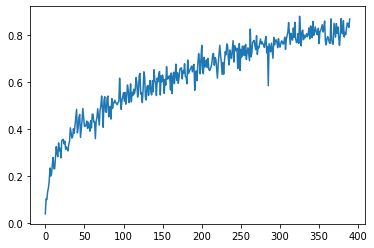

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_average': 0.6464646458625793,
 'test_accuracy_f1': 0.6464646464646465,
 'test_loss': 1.0524497032165527}
--------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:
m = first_time(gpus=1)

In [ ]:
m

Classifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

Заполняем таблицу предсказаний

In [ ]:
def make_csv():

  import os
  import pandas as pd
  from torchvision.io import read_image
  from PIL import Image
  from torch import Tensor
  from torch.autograd import Variable

  TRANSFORM_TEST = transforms.Compose([
      # transforms.Grayscale(),
      transforms.Resize([224, 224]),
      transforms.ToTensor(),
  ])

  def predict(image):
      image_tensor = TRANSFORM_TEST(image).float()
      image_tensor = image_tensor.unsqueeze_(0)
      input = Variable(image_tensor)
      output = model(input)
      index = output.data.cpu().numpy().argmax()
      return index


  model = m.model
  # model.load_state_dict(torch.load("/content/drive/My Drive/my_model"))
  model.eval()

  ans_csv = pd.read_csv("/content/drive/MyDrive/footballteams/sample_submission.csv")

  path = '/content/drive/MyDrive/footballteams/Test/GrayScaleTest'


  for dirname, _, filenames in os.walk(path):
    for file in filenames:
      imgpath = path + '/' + file
      image = Image.open(imgpath)
      pred = predict(image) 

      ans_csv.loc[ans_csv['img_name'] == file, 'label'] = pred

  ans_csv.to_csv(r"/content/drive/MyDrive/footballteams/my_submission_2.csv", index=False, sep=",")
  return ans_csv


In [ ]:
csv = make_csv()

In [ ]:
csv

,img_name,label
0,83b415b4-7839-11ec-983f-a9a6a9ca2e41.jpg,3
1,83b41561-7839-11ec-983f-a9a6a9ca2e41.jpg,2
2,83b4186a-7839-11ec-983f-a9a6a9ca2e41.jpg,5
3,83b41900-7839-11ec-983f-a9a6a9ca2e41.jpg,2
4,83b41743-7839-11ec-983f-a9a6a9ca2e41.jpg,4
...,...,...
1172,83b4156e-7839-11ec-983f-a9a6a9ca2e41.jpg,2
1173,83b6738a-7839-11ec-983f-a9a6a9ca2e41.jpg,6
1174,83b41623-7839-11ec-983f-a9a6a9ca2e41.jpg,0
1175,83b41535-7839-11ec-983f-a9a6a9ca2e41.jpg,2


# **Вывод:**

1)     **Разрешить проблему переобучения** 

*   сначала попробовать улучшить трансформации изображений
*   попробовать добавить предобучение на больших датасетах, например COCO, где модель сначала научится распознавать фигуры людей
*   если и это не поможет, изменить архетиктуру модели

2)     **Естественно, 30-50 эпох это очень мало!**

К сожалению, у меня не хватило времени и gpu, чтобы посмотреть, какой результат получится про более длительном обучении